# CTR Structured Test

We want to test two different ad copy, the first of which is the control copy that has the traditional "Save $500" phrase vs. the test copy which has the "Switch and Save" phrase. We want to see if there is a performance difference between the two.

Null hypothesis - the CTR of the control copy is equal to the CTR of the test copy 
Alternate hypothesis - the CTR of the control copy is not equal to the CTR of the test copy

We expect the control copy to have a CTR of .04%

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil #to round to the next whole number

In [2]:
%matplotlib inline

In [3]:
# Calculating effect size based on our expected rates (.04% CTR for control, .06% CTR for for test)
effect_size = sms.proportion_effectsize(0.004, 0.006)

# Calculating sample size needed at 95% confidence with a power of 80%)
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                 

# Rounding up to next whole number                          
required_n = ceil(required_n)                                                   

print(required_n) #we would need to serve 19,328 impressions for each of the two groups before we can determine statistical significance

19328


In [4]:
#create our control click data
control_clicks = ceil(required_n*(.003))
control_clicks_array = np.ones(control_clicks)

#create our control non-click data
control_nonclicks = ceil(required_n*(1-.003))
control_nonclicks_array = np.zeros(control_nonclicks)

#concatenate the two control arrays and shuffle it
control = np.concatenate((control_clicks_array, control_nonclicks_array), axis=None)
np.random.shuffle(control)

In [5]:
#create control dataframe
control = pd.DataFrame(control, columns=['Clicks'])
control['Group'] = 'Control'
control.reset_index(inplace=True)
control = control.rename(columns={"index": "ImpressionID"})

In [6]:
control

,ImpressionID,Clicks,Group
0,0,0.0,Control
1,1,0.0,Control
2,2,0.0,Control
3,3,0.0,Control
4,4,0.0,Control
...,...,...,...
19324,19324,0.0,Control
19325,19325,0.0,Control
19326,19326,0.0,Control
19327,19327,0.0,Control


In [36]:
#create our test click data
test_clicks = ceil(required_n*(.006))
test_clicks_array = np.ones(test_clicks)

#create our test non-click data
test_nonclicks = ceil(required_n*(1-.006))
test_nonclicks_array = np.zeros(test_nonclicks)

#concatenate the two control arrays and shuffle it
test = np.concatenate((test_clicks_array, test_nonclicks_array), axis=None)
np.random.shuffle(test)

In [37]:
#create test dataframe
test = pd.DataFrame(test, columns=['Clicks'])
test['Group'] = 'Test'
test.reset_index(inplace=True)
test = test.rename(columns={"index": "ImpressionID"})
test['ImpressionID'] += required_n #give the test data different ImpressionIDs from the control data

In [38]:
test

,ImpressionID,Clicks,Group
0,19328,0.0,Test
1,19329,0.0,Test
2,19330,0.0,Test
3,19331,0.0,Test
4,19332,0.0,Test
...,...,...,...
19324,38652,0.0,Test
19325,38653,0.0,Test
19326,38654,0.0,Test
19327,38655,0.0,Test


In [39]:
#concatenate the test and control data
ab_test = pd.concat([control, test], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [40]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38658 entries, 0 to 38657
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImpressionID  38658 non-null  int64  
 1   Clicks        38658 non-null  float64
 2   Group         38658 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 906.2+ KB


In [41]:
#creates a panda Series with no columns
clickthrough_rates = ab_test.groupby('Group')['Clicks']

# Std. deviation of the proportion
std_p = lambda x: np.std(x, ddof=0)
# Std. error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x, ddof=0)

clickthrough_rates = clickthrough_rates.agg([np.mean, std_p, se_p])
clickthrough_rates.columns = ['clickthrough_rate', 'std_deviation', 'std_error']

clickthrough_rates

,clickthrough_rate,std_deviation,std_error
Group,,,
Control,0.003001,0.054696,0.000393
Test,0.006001,0.077236,0.000556


Text(0, 0.5, 'Clickthrough Rate')

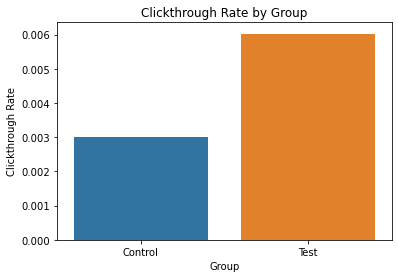

In [42]:
#visualize the performance of the control and treatment groups
sns.barplot(x=ab_test['Group'], y=ab_test['Clicks'], ci=False)

plt.title("Clickthrough Rate by Group")
plt.ylabel("Clickthrough Rate")

In [43]:
#test the hypothesis with the normal approximation (z-test)
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [44]:
control_results = ab_test[ab_test['Group'] == 'Control']['Clicks']
test_results = ab_test[ab_test['Group'] == 'Test']['Clicks']

n_con = control_results.count()
n_test = test_results.count()
successes = [control_results.sum(), test_results.sum()]
nobs = [n_con, n_test]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_test), (upper_con, upper_test) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}') #f' is an f-string that allows you to run expressions in real time in curly brackets
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for test group: [{lower_test:.3f}, {upper_test:.3f}]')

z statistic: -4.41
p-value: 0.000
ci 95% for control group: [0.002, 0.004]
ci 95% for test group: [0.005, 0.007]


In [50]:
#what if we do a one-tailed t-test with the alternate hypothesis that the test group has a greater mean?
from scipy.stats import ttest_ind

ttest, pval = ttest_ind(test_results, control_results, alternative="greater") #first data should be the test

if pval <0.05:
      print("we reject null hypothesis")
else:
      print("we fail to reject the null hypothesis")

we reject null hypothesis


In [48]:
pval

5.2331486351443576e-06